<a href="https://colab.research.google.com/github/dsobhani8/Env_Adjusted_TM/blob/main/horseshoe_model_iii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dsobhani8/invTM_data
!git clone https://github.com/dsobhani8/Env_Adjusted_TM

fatal: destination path 'invTM_data' already exists and is not an empty directory.
fatal: destination path 'Env_Adjusted_TM' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import math
import csv

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal, Distribution, HalfCauchy

import nltk
nltk.download('punkt')
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checks whether a GPU is available and chooses the GPU if it is


This code first reads a CSV file containing combined data, then splits it into a training set and a test set. Next, it tokenizes and vectorizes the 'text' column from the training and test data. To upload your personal dataset, replace the path in the pd.read_csv function with the path to your CSV file. Ensure the environment information exists in a column named 'source'.
The environment index is acquired by mapping the unique values in the 'source' column of the training data to unique integer indices. For example, if the sources were 'Fox', 'NBC', and 'CBS', they would be represented as 0, 1, and 2 respectively.

In [4]:
file_path = "/content/Env_Adjusted_TM/data/political_ads_stopwords.txt"

with open(file_path, 'r') as file:
    stopwords_list = file.readlines()

all_stopwords = [word.strip() for word in stopwords_list]

In [5]:
class LemmaTokenizer:
	def __init__(self):
		self.wnl = WordNetLemmatizer()
	def __call__(self, doc):
		return [t for t in word_tokenize(doc) if str.isalpha(t)]

Your data goes here. It should be loaded as a dataframe with columns 'text' and 'source'

In [6]:
# file_path = 'path/to/your/csvfile.csv'  # Replace with your CSV file path
# combined_data = pd.read_csv(file_path)

# # Splitting the data into training and testing sets
# train_data = _
# test_data = _

In [7]:
#three channels training data, iid test
combined_data=pd.read_csv('/content/Env_Adjusted_TM/data/three_channel_train.csv')
train_data = combined_data.sample(n=16000, random_state=22)
test_data = combined_data.drop(train_data.index).sample(n=2000, random_state=20)

In [8]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1, 1), stop_words=all_stopwords, max_df=0.4, min_df=0.0006)

docs_word_matrix_raw = vectorizer.fit_transform(train_data['text'])
test_data_word_matrix_raw = vectorizer.transform(test_data['text'])

env_mapping = {value: index for index, value in enumerate(train_data['source'].unique())}
env_index = train_data['source'].apply(lambda x: env_mapping[x])

docs_word_matrix_tensor = torch.from_numpy(docs_word_matrix_raw.toarray()).float().to(device)
env_index_tensor = torch.from_numpy(env_index.to_numpy()).long().to(device)
test_data_word_matrix_tensor = torch.from_numpy(test_data_word_matrix_raw.toarray()).float().to(device)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sha', 'words'] not in stop_words.
  warnings.warn(


In [9]:
print(docs_word_matrix_tensor.shape)
env_index.shape

torch.Size([16000, 3751])


(16000,)

The code consists of two classes, Horseshoe and LDA. The Horseshoe class represents a horseshoe distribution. The Env_TM class is a topic model variant which models topics within a collection of documents and includes the parameters, priors, and a forward method to calculate the topic distribution for a given bag-of-words (BoW) representation and environment index.

In [10]:
class EnvTM(nn.Module):
    def __init__(self, num_topics, num_words, num_envs, device='cpu'):
        super(EnvTM, self).__init__()

        def init_param(shape):
            return nn.Parameter(torch.randn(shape, device=device))

        def init_param_zeros(shape):
            return nn.Parameter(torch.zeros(shape, device=device))

        self.num_topics, self.num_words, self.num_envs = num_topics, num_words, num_envs

        # Global Beta, β_{0,k} ~ 𝒩(·,·)
        self.beta = init_param([num_topics, num_words])
        self.beta_logvar = init_param_zeros([num_topics, num_words])
        self.beta_prior = Normal(torch.zeros([num_topics, num_words], device=device), torch.ones([num_topics, num_words], device=device))

        # Lambda parameters, λ_{e,k} ~ ℂ+(0,1)

        self.lambda_ek = nn.Parameter(torch.randn([num_envs, num_topics, num_words], device=device))

        # self.lambda_ek = nn.Parameter(torch.distributions.HalfCauchy(scale=torch.tensor(1.0, device=device)).rsample([num_envs, num_topics, num_words]))

        # Tau parameter, τ ~ Half-Cauchy(0,1)
        self.tau = nn.Parameter(torch.distributions.HalfCauchy(scale=torch.tensor(1.0, device=device)).rsample())

        # Gamma parameters, γ_{e,k} ~ 𝒩(0, λ_{e,k}^2 τ^2)
        self.gamma = init_param_zeros([num_envs, num_topics, num_words])  # Initialize with zeros to reflect mean
        self.gamma_logvar = init_param_zeros([num_envs, num_topics, num_words]) # Variance will be determined by λ and τ

        # Variational Parameters for β_{e,k} ~ 𝒩(β_{0,k} + γ_{e_{1:ℰ},k},·)
        self.beta_ek = init_param([num_envs, num_topics, num_words])
        self.beta_ek_logvar = init_param_zeros([num_envs, num_topics, num_words])

        # Global Theta, θ_{d} ~ 𝒩(·,·)
        self.theta_global_prior = Normal(torch.zeros(num_topics, device=device), torch.ones(num_topics, device=device))

        # Neural network for document-specific theta_global
        self.theta_global_net = nn.Sequential(
            nn.Linear(num_words, 50),
            nn.ReLU(),
            nn.Linear(50, num_topics * 2)  # Produces both mean and variance
        )

        # Environment-specific theta parameters, θ_{e,d,i} ~ 𝒩(·,·)
        self.theta_env_prior = Normal(torch.zeros(num_topics, device=device), torch.ones(num_topics, device=device))
        self.theta_env_mu = init_param([num_envs, num_topics])
        self.theta_env_logvar = init_param_zeros([num_envs, num_topics])

    def forward(self, bow, env_index):
        batch_size, vocab_size = bow.size()

        # Compute document-specific theta_global mean and variance
        self.theta_global_params = self.theta_global_net(bow)
        theta_global_mu, theta_global_logvar = self.theta_global_params.split(self.num_topics, dim=-1)
        theta_global_logvar = theta_global_logvar.add(1e-8)


        # Sample 𝜃_{d} from the Normal distribution
        theta_global = Normal(theta_global_mu, torch.exp(0.5 * theta_global_logvar).add(1e-8)).rsample()

        # Sample environment-specific theta
        theta_env_mu = self.theta_env_mu[env_index]
        theta_env_logvar = self.theta_env_logvar[env_index]
        theta_env = Normal(theta_env_mu, torch.exp(0.5 * theta_env_logvar).add(1e-8)).rsample()

        # Combine theta_global and theta_env
        theta = theta_global + theta_env
        theta_softmax = F.softmax(theta, dim=-1)

        # Sample global beta (β₀,k)
        beta_dist = Normal(self.beta, torch.exp(0.5 * self.beta_logvar).add(1e-8))
        beta_sample = beta_dist.rsample()

        # Generate gamma (γ_{e,k}) variance and sample gamma
        gamma_variance = (self.lambda_ek[env_index] ** 2) * (self.tau ** 2)
        gamma_dist = Normal(torch.zeros_like(gamma_variance), torch.sqrt(gamma_variance).add(1e-8))
        gamma_sample = gamma_dist.rsample() # Sampled from Normal(0, gamma_variance)


        # Compute mean for beta_ek and sample
        beta_ek_mean = beta_sample + gamma_sample
        beta_ek_dist = Normal(beta_ek_mean, torch.exp(0.5 * self.beta_ek_logvar[env_index]).add(1e-8))
        beta_ek_sample = beta_ek_dist.rsample()

        # Apply softmax to beta_ek_sample
        beta_gamma_ek_softmax = F.softmax(beta_ek_sample, dim=-1)

        # Combine theta and beta_ek_sample
        z = theta_softmax @ beta_gamma_ek_softmax
        return z

In [11]:
def calculate_kl_divergences(EnvTM, env):
    theta_global_mu, theta_global_logvar = EnvTM.theta_global_params.split(EnvTM.num_topics, dim=-1)
    theta_global_logvar = theta_global_logvar.add(1e-8)
    theta_global = Normal(theta_global_mu, torch.exp(0.5 * theta_global_logvar).add(1e-8))
    theta_global_kl = torch.distributions.kl.kl_divergence(theta_global, EnvTM.theta_global_prior).sum()
    # print('theta_global_kl', theta_global_kl)

    theta_env_mu = EnvTM.theta_env_mu[env]
    theta_env_logvar = EnvTM.theta_env_logvar[env]
    theta_env = Normal(theta_env_mu, torch.exp(0.5 * theta_env_logvar).add(1e-8))
    theta_env_kl = torch.distributions.kl.kl_divergence(theta_env, EnvTM.theta_env_prior).sum()
    # print('theta_env_kl', theta_env_kl)


    beta = Normal(EnvTM.beta, torch.exp(0.5 * EnvTM.beta_logvar))
    beta_kl = torch.distributions.kl.kl_divergence(beta, EnvTM.beta_prior).sum()
    # print('beta_kl', beta_kl)

    beta_ek = Normal(EnvTM.beta_ek[env], torch.exp(0.5 * EnvTM.beta_ek_logvar[env]))
    beta_ek_prior = Normal(EnvTM.beta.unsqueeze(0) + EnvTM.gamma[env], torch.ones_like(EnvTM.beta_ek[env]))
    beta_ek_kl = torch.distributions.kl.kl_divergence(beta_ek, beta_ek_prior).sum()
    # print('beta_ek_kl', beta_ek_kl)


    lambda_ek_value = EnvTM.lambda_ek[env]
    tau_value = EnvTM.tau
    # Calculate gamma_scale
    gamma_scale_value = (lambda_ek_value**2) * (tau_value**2)
    gamma_prior = Normal(torch.zeros_like(gamma_scale_value), torch.sqrt(gamma_scale_value).add(1e-8))
    gamma = Normal(EnvTM.gamma[env], torch.exp(0.5 * EnvTM.gamma_logvar[env]).add(1e-8))
    gamma_kl = torch.distributions.kl.kl_divergence(gamma, gamma_prior).sum()


    return theta_global_kl, theta_env_kl, beta_kl, gamma_kl, beta_ek_kl

In [12]:
def bbvi_update(minibatch, env_index, EnvTM, optimizer, n_samples):
    optimizer.zero_grad()
    elbo_accumulator = torch.zeros(1, device=minibatch.device)  # Initialize as tensor

    # Get the unique environment indexes
    unique_envs = torch.unique(env_index)

    for env in unique_envs:
        # Get the mask where current environment matches
        mask = (env_index == env)

        # Use the mask to get the current minibatch and number of samples
        current_minibatch = minibatch[mask]
        current_n_samples = n_samples * mask.sum().item() / minibatch.size()[0]
        # Pass the current minibatch to the model
        z = EnvTM(current_minibatch, env)
        theta_global_params = EnvTM.theta_global_net(current_minibatch)

        theta_global_kl, theta_env_kl, beta_kl, gamma_kl, beta_ek_kl = calculate_kl_divergences(EnvTM, env)
        elbo = (current_minibatch * z.log()).sum(-1).mul(current_n_samples).sub(theta_global_kl + theta_env_kl + beta_kl + gamma_kl + beta_ek_kl)
        elbo_accumulator += elbo.sum()

    (-elbo_accumulator).backward()
    optimizer.step()

    return elbo_accumulator.item()

The hyperparameters such as num_topics, num_envs, num_epochs, minibatch_size, and the learning rate (lr) in this model are configurable based on the specific use case and data characteristics.

In [13]:
def train_model(EnvTM, docs_word_matrix_tensor, env_index_tensor, num_epochs=80, minibatch_size=1024, lr=0.01):
    EnvTM = EnvTM.to(device)  # move your model to the GPU
    optimizer = torch.optim.Adam(EnvTM.parameters(), lr=lr)

    docs_word_matrix_tensor = docs_word_matrix_tensor.to(device)  # move your tensors to the GPU
    env_index_tensor = env_index_tensor.to(device)  # move your tensors to the GPU

    for epoch in range(num_epochs):
        elbo_accumulator = 0.0

        # Randomly permute data for minibatches
        permutation = torch.randperm(docs_word_matrix_tensor.size()[0])

        for i in range(0, docs_word_matrix_tensor.size()[0], minibatch_size):
            # Get minibatch
            indices = permutation[i:i+minibatch_size]
            minibatch = docs_word_matrix_tensor[indices]

            # Get corresponding environment indices
            minibatch_env_index = env_index_tensor[indices]

            # BBVI update for the minibatch
            elbo = bbvi_update(minibatch, minibatch_env_index, EnvTM, optimizer, docs_word_matrix_tensor.size()[0])

            # Accumulate ELBO
            elbo_accumulator += elbo

        # Calculate average ELBO for the epoch
        avg_elbo = elbo_accumulator / (docs_word_matrix_tensor.size()[0] / minibatch_size)

        print(f'Epoch: {epoch+1}, Average ELBO: {avg_elbo}')


In [14]:
num_topics = 6
num_envs = 3
env_tm_model = EnvTM(num_topics=num_topics, num_words=len(vectorizer.get_feature_names_out()), num_envs=num_envs, device=device)

train_model(env_tm_model, docs_word_matrix_tensor, env_index_tensor, num_epochs=140, minibatch_size=1024, lr=0.01)

Epoch: 1, Average ELBO: -882927879569.408
Epoch: 2, Average ELBO: -2460318515.2
Epoch: 3, Average ELBO: -2078285275.136
Epoch: 4, Average ELBO: -1934388387.84
Epoch: 5, Average ELBO: -1847928225.792
Epoch: 6, Average ELBO: -1780799954.944
Epoch: 7, Average ELBO: -1726091476.992
Epoch: 8, Average ELBO: -1674588958.72
Epoch: 9, Average ELBO: -1632100900.864
Epoch: 10, Average ELBO: -1596821553.152
Epoch: 11, Average ELBO: -1562382172.16
Epoch: 12, Average ELBO: -1535331254.272
Epoch: 13, Average ELBO: -1507580002.304
Epoch: 14, Average ELBO: -1484493549.568
Epoch: 15, Average ELBO: -1461747396.608
Epoch: 16, Average ELBO: -1444181401.6
Epoch: 17, Average ELBO: -1424054202.368
Epoch: 18, Average ELBO: -1408511094.784
Epoch: 19, Average ELBO: -1395312009.216
Epoch: 20, Average ELBO: -1380410273.792
Epoch: 21, Average ELBO: -1365427650.56
Epoch: 22, Average ELBO: -1353968656.384
Epoch: 23, Average ELBO: -1342981869.568
Epoch: 24, Average ELBO: -1332079972.352
Epoch: 25, Average ELBO: -13213

In [15]:
def evaluate_model(env_tm_model, test_data_word_matrix_tensor):
    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env_tm_model.to(device)
    # Set the model to evaluation mode
    env_tm_model.eval()

    with torch.no_grad():
        theta_test_params = env_tm_model.theta_global_net(test_data_word_matrix_tensor)
        theta_test_mu, theta_test_logvar = theta_test_params.split(env_tm_model.num_topics, dim=-1)
        theta_test_dist = Normal(theta_test_mu, torch.exp(0.5 * theta_test_logvar).add(1e-8))
        theta_test = theta_test_dist.rsample()
        theta_test_softmax = F.softmax(theta_test, dim=-1)
        beta_test_softmax = F.softmax(env_tm_model.beta.to(device), dim=-1)
        log_likelihood = torch.mm(theta_test_softmax, beta_test_softmax)
        N = torch.sum(test_data_word_matrix_tensor)
        log_perplex = -torch.sum(torch.log(log_likelihood) * test_data_word_matrix_tensor) / N
        perplexity = torch.exp(log_perplex)

    return perplexity

perplexity = evaluate_model(env_tm_model, test_data_word_matrix_tensor)
print(f'Test Perplexity: {perplexity}')

Test Perplexity: 950.595458984375


In [16]:
def print_top_words(env_tm_model, vectorizer, num_top_words):
    beta = torch.nn.functional.softmax(env_tm_model.beta, dim=1)  # Convert to probabilities
    beta = beta.cpu()  # Move to CPU
    for i, topic in enumerate(beta):
        top_words = topic.topk(num_top_words).indices
        print(f'Topic {i+1}: {[vectorizer.get_feature_names_out()[i] for i in top_words]}')



In [17]:
print_top_words(env_tm_model, vectorizer, num_top_words=10)

Topic 1: ['voted', 'responsible', 'national', 'million', 'content', 'home', 'companies', 'paid', 'class', 'middle']
Topic 2: ['jobs', 'plan', 'children', 'energy', 'help', 'businesses', 'law', 'fighting', 'lost', 'republicans']
Topic 3: ['america', 'advertising', 'content', 'country', 'american', 'party', 'illegal', 'dollars', 'oil', 'truth']
Topic 4: ['taxes', 'government', 'spending', 'conservative', 'republican', 'economy', 'politicians', 'values', 'debt', 'politician']
Topic 5: ['health', 'pay', 'medicare', 'security', 'social', 'campaign', 'seniors', 'obamacare', 'insurance', 'veterans']
Topic 6: ['tax', 'governor', 'families', 'cut', 'congressman', 'family', 'job', 'education', 'schools', 'kids']


In [18]:
def print_top_words(env_tm_model, vectorizer, num_top_words):
    global_beta = torch.nn.functional.softmax(env_tm_model.beta, dim=1)  # Convert to probabilities
    gamma = env_tm_model.gamma

    # Print top words for global beta
    print("Top words for global beta:")
    for i, topic in enumerate(global_beta):
        top_words = topic.topk(num_top_words).indices
        print(f'Topic {i+1}: {[vectorizer.get_feature_names_out()[i] for i in top_words]}')

    # Print top words for gamma
    print("\nTop words for gamma:")
    for env_index, env_gamma in enumerate(gamma):
        print(f"Environment {env_index+1}:")
        for i, topic in enumerate(env_gamma):
            top_words = topic.topk(num_top_words).indices
            print(f'Topic {i+1}: {[vectorizer.get_feature_names_out()[i] for i in top_words]}')
        print()


env0=NBC, env1=FOX, env2=CBS

In [19]:
print_top_words(env_tm_model, vectorizer, num_top_words=10)

Top words for global beta:
Topic 1: ['voted', 'responsible', 'national', 'million', 'content', 'home', 'companies', 'paid', 'class', 'middle']
Topic 2: ['jobs', 'plan', 'children', 'energy', 'help', 'businesses', 'law', 'fighting', 'lost', 'republicans']
Topic 3: ['america', 'advertising', 'content', 'country', 'american', 'party', 'illegal', 'dollars', 'oil', 'truth']
Topic 4: ['taxes', 'government', 'spending', 'conservative', 'republican', 'economy', 'politicians', 'values', 'debt', 'politician']
Topic 5: ['health', 'pay', 'medicare', 'security', 'social', 'campaign', 'seniors', 'obamacare', 'insurance', 'veterans']
Topic 6: ['tax', 'governor', 'families', 'cut', 'congressman', 'family', 'job', 'education', 'schools', 'kids']

Top words for gamma:
Environment 1:
Topic 1: ['taken', 'financing', 'foreclosure', 'billionaires', 'exploiting', 'aftab', 'rebuild', 'proudly', 'answers', 'admits']
Topic 2: ['costly', 'steered', 'family', 'defended', 'spreading', 'heading', 'damage', 'kemp', 

Top words in gamma environment 0: ['powerful', 'blessing', 'corps', 'faced', 'sweetheart', 'affordable', 'books', 'ball']
Top words in beta:                ['tax', 'governor', 'families', 'cut', 'congressman', 'family', 'job', 'education']


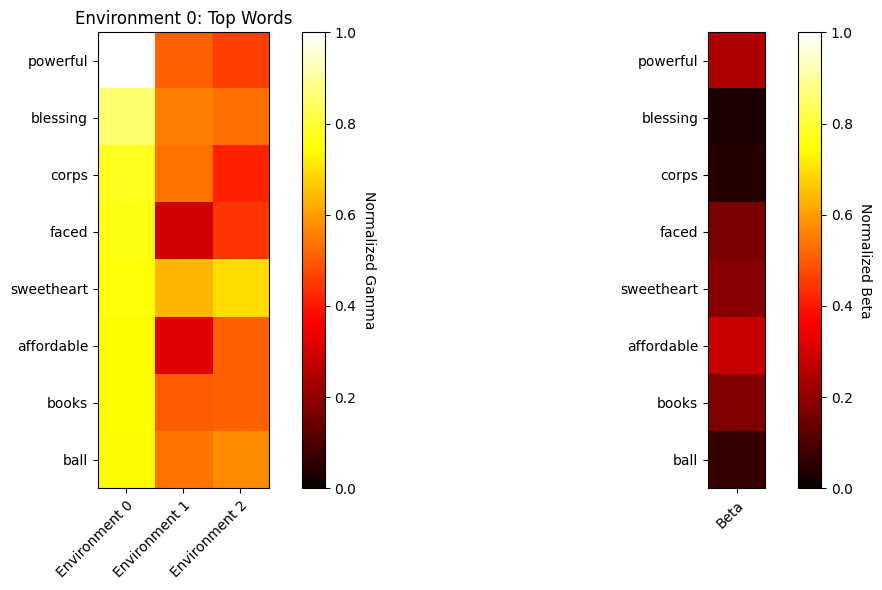

Top words in gamma environment 1: ['bozeman', 'paper', 'devastate', 'guessed', 'criminals', 'disagrees', 'boosting', 'criminal']
Top words in beta:                ['tax', 'governor', 'families', 'cut', 'congressman', 'family', 'job', 'education']


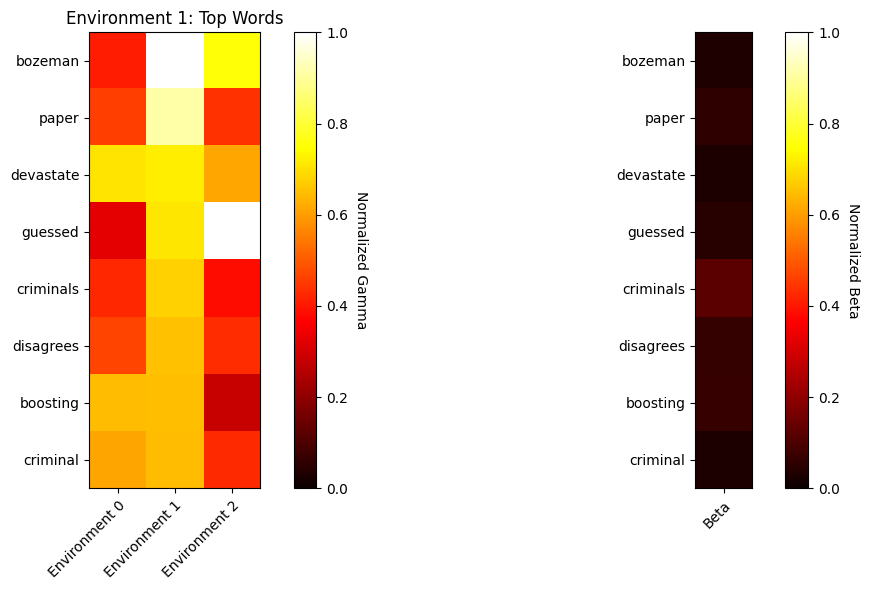

Top words in gamma environment 2: ['guessed', 'interests', 'bozeman', 'tools', 'sweetheart', 'exxon', 'northern', 'seals']
Top words in beta:                ['tax', 'governor', 'families', 'cut', 'congressman', 'family', 'job', 'education']


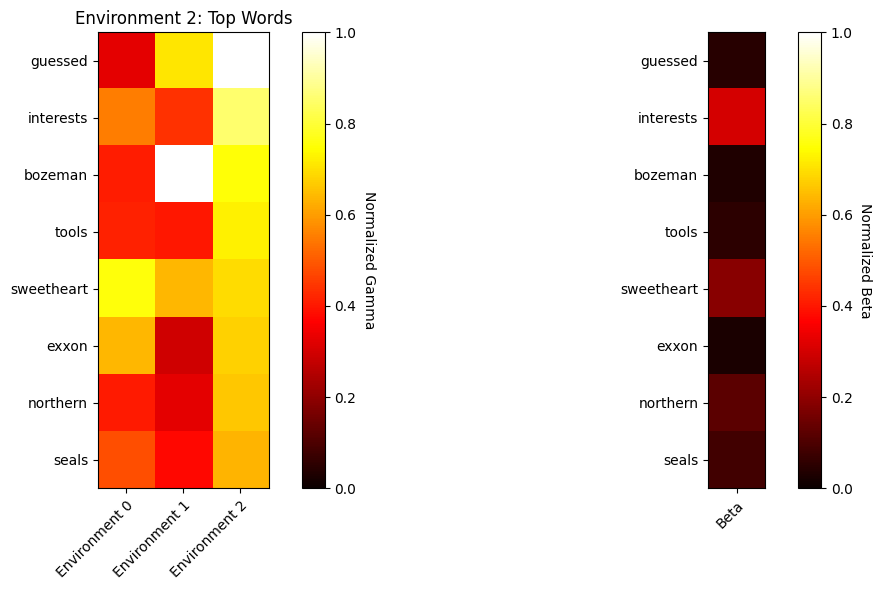

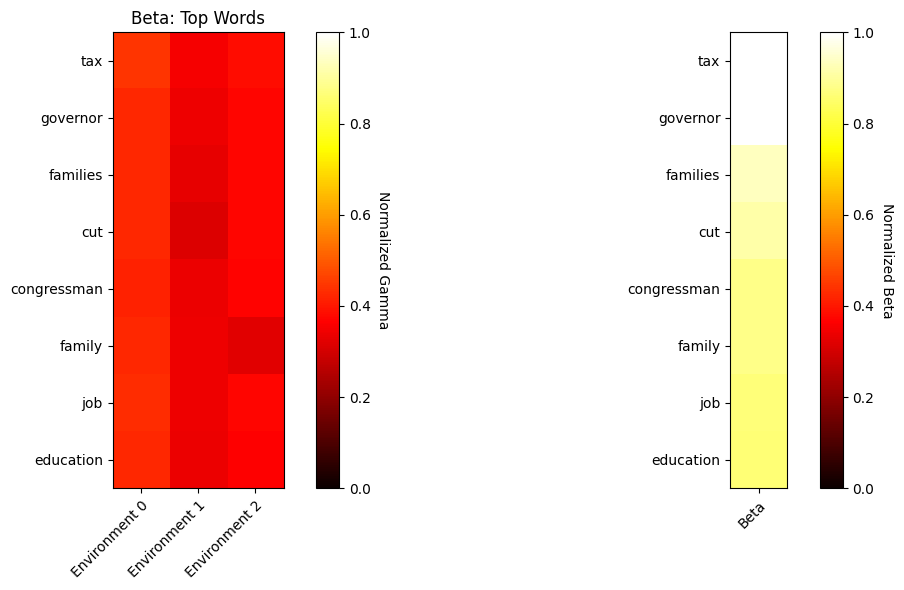

In [20]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def get_top_indices_values(arr, top_n=8):
    indices = np.argsort(-arr)[:top_n]
    values = arr[indices]
    return indices, values

def get_words(vocabulary, indices):
    return [vocabulary[i] for i in indices]

def plot_gamma_beta_heatmaps(gamma_data, beta_data, words, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Defining the color scale between 0 and 1
    im1 = ax1.imshow(gamma_data.T, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    im2 = ax2.imshow(beta_data.T.reshape(-1, 1), cmap='hot', interpolation='nearest', vmin=0, vmax=1)

    num_environments = gamma_data.shape[0]
    environments = [f'Environment {i}' for i in range(num_environments)]

    # Settings for gamma heatmap
    ax1.set_yticks(np.arange(len(words)))
    ax1.set_xticks(np.arange(num_environments))
    ax1.set_yticklabels(words)
    ax1.set_xticklabels(environments)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar1 = fig.colorbar(im1, ax=ax1)
    cbar1.ax.set_ylabel("Normalized Gamma", rotation=-90, va="bottom")

    # Settings for beta grid
    ax2.set_yticks(np.arange(len(words)))
    ax2.set_xticks([0])
    ax2.set_yticklabels(words)
    ax2.set_xticklabels(['Beta'])
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar2 = fig.colorbar(im2, ax=ax2)
    cbar2.ax.set_ylabel("Normalized Beta", rotation=-90, va="bottom")

    ax1.set_title(title)
    fig.tight_layout()
    plt.show()

def analyze_topic(lda, vocabulary, topic_index, top_n=8):
    # Normalize the entire beta array for the specific topic
    beta_values = normalize(lda.beta[topic_index, :].cpu().detach().numpy())

    # Normalize the entire gamma arrays for the specific topic in all environments
    num_environments = lda.gamma.shape[0]
    gamma_values = [normalize(lda.gamma[i, topic_index, :].cpu().detach().numpy()) for i in range(num_environments)]

    # Get the top beta indices and values
    beta_indices, _ = get_top_indices_values(beta_values, top_n)

    for env_index, gamma_value in enumerate(gamma_values):
        # Get the top gamma indices and values
        gamma_indices, _ = get_top_indices_values(gamma_value, top_n)

        # Get the corresponding words from the vocabulary
        gamma_words = get_words(vocabulary, gamma_indices)
        beta_words = get_words(vocabulary, beta_indices)

        # Print the top words
        print(f"Top words in gamma environment {env_index}:", gamma_words)
        print("Top words in beta:               ", beta_words)

        # Get the gamma and beta values for top words
        gamma_values_top_words = [gamma_values[i][gamma_indices] for i in range(num_environments)]
        beta_values_top_words = beta_values[gamma_indices]

        # Plot the heatmaps
        plot_gamma_beta_heatmaps(np.array(gamma_values_top_words), beta_values_top_words, gamma_words, f"Environment {env_index}: Top Words")

    # Gamma and Beta values for top words in beta
    gamma_values_beta = [gamma_values[i][beta_indices] for i in range(num_environments)]
    beta_values_beta = beta_values[beta_indices]
    beta_words = get_words(vocabulary, beta_indices)

    # Plot the heatmaps for the top words in beta
    plot_gamma_beta_heatmaps(np.array(gamma_values_beta), beta_values_beta, beta_words, "Beta: Top Words")


vocabulary = list(vectorizer.get_feature_names_out())

# Analyzing topic 4 with 8 top words
analyze_topic(env_tm_model, vocabulary, topic_index=5, top_n=8)


In [21]:
def analyze_gamma_per_environment(model, threshold=1e-3):
    gamma_values = model.gamma.detach().cpu().numpy()

    for env_index in range(gamma_values.shape[0]):
        print(f"Environment {env_index}:")
        gamma_env_values = gamma_values[env_index]

        close_to_zero = np.abs(gamma_env_values) < threshold
        sparsity_percentage = 100 * np.sum(close_to_zero) / gamma_env_values.size

        print(f"Sparsity Percentage: {sparsity_percentage}%")
        print(f"Mean of Gamma: {np.mean(gamma_env_values)}")
        print(f"Standard Deviation of Gamma: {np.std(gamma_env_values)}")
        plt.hist(gamma_env_values.flatten(), bins=50)
        plt.title(f"Histogram of Gamma Values for Environment {env_index}")
        plt.show()


Environment 0:
Sparsity Percentage: 67.50199946680885%
Mean of Gamma: -3.8706970372004434e-05
Standard Deviation of Gamma: 0.0014756247401237488


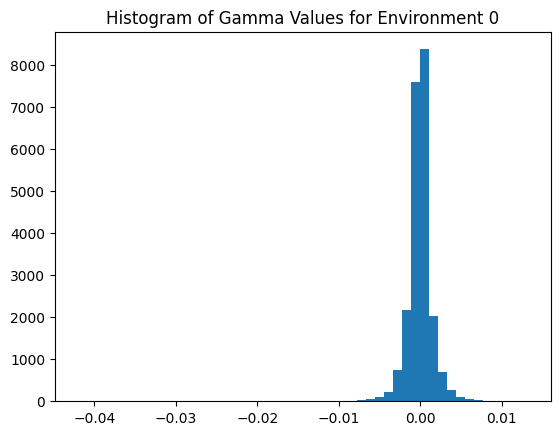

Environment 1:
Sparsity Percentage: 68.03519061583577%
Mean of Gamma: -2.4533119358238764e-05
Standard Deviation of Gamma: 0.0014470232417806983


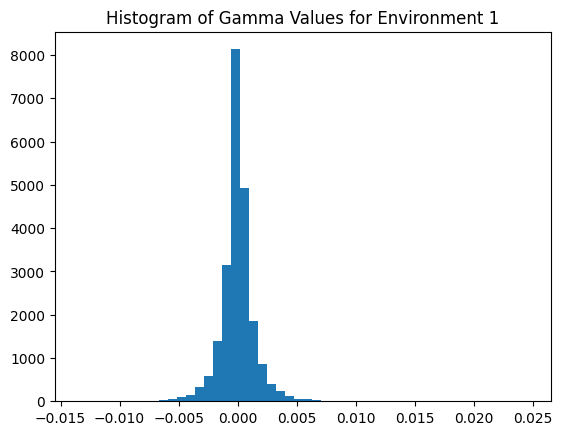

Environment 2:
Sparsity Percentage: 67.51532924553453%
Mean of Gamma: -1.695362698228564e-05
Standard Deviation of Gamma: 0.0014648009091615677


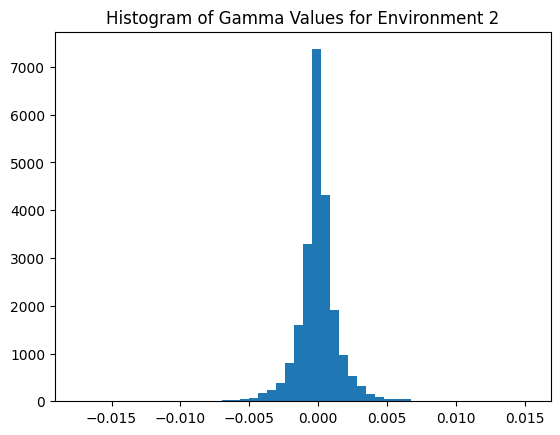

In [22]:
analyze_gamma_per_environment(env_tm_model)
